### Uncomment and run the below code block if you do not already have the below libraries installed.

In [22]:
# !pip install sklearn
# !pip install pandas

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import pandas as pd
import numpy as np
import collections
import time
from sklearn import decomposition
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import LogisticRegression 
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline
print(sklearn.__version__)

1.0.2


In [25]:
# make sure your data matches the given name below, else edit it to desired name
# note: csv is assumed to be stored in /content/ . Change path if necessary
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/STO_data.csv')
# check that the data is imported properly
df.head()

,SM,MM,shader,core,spunit,l1,latency,dl2,IPC
0,35,1,32,12,2048,64,82,128,291.7727
1,35,1,32,12,2048,64,82,64,291.7376
2,35,1,32,12,1024,32,82,128,291.7727
3,35,1,32,12,1536,64,35,64,291.6447
4,35,1,32,12,1024,64,20,128,291.4724


### Exploratory Data Analysis:

In [26]:
df.mean()

SM           80.014477
MM            4.957774
shader       73.497210
core         27.744232
spunit     1538.316393
l1           47.949329
latency      45.611220
dl2          95.966219
IPC         505.207977
dtype: float64

In [27]:
df.median()

SM           80.0000
MM            5.0000
shader       64.0000
core         24.0000
spunit     1536.0000
l1           32.0000
latency      35.0000
dl2          64.0000
IPC         494.1624
dtype: float64

In [28]:
df.tail()

,SM,MM,shader,core,spunit,l1,latency,dl2,IPC
6626,15,1,128,48,2048,32,82,64,243.7642
6627,15,1,64,48,2048,64,20,64,246.1584
6628,15,1,64,24,1536,32,82,128,245.2458
6629,15,1,32,12,1536,32,35,128,244.0616
6630,15,1,128,24,2048,32,20,64,246.1584


In [29]:
df.describe()

,SM,MM,shader,core,spunit,l1,latency,dl2,IPC
count,6631.000000,6631.000000,6631.000000,6631.000000,6631.000000,6631.000000,6631.000000,6631.000000,6631.000000
mean,80.014477,4.957774,73.497210,27.744232,1538.316393,47.949329,45.611220,95.966219,505.207977
std,21.733927,2.868884,39.733744,14.930377,418.606939,16.001126,26.398654,32.002395,176.278193
min,3.000000,1.000000,32.000000,12.000000,1024.000000,32.000000,20.000000,64.000000,65.948000
25%,75.000000,2.000000,32.000000,12.000000,1024.000000,32.000000,20.000000,64.000000,357.469100
50%,80.000000,5.000000,64.000000,24.000000,1536.000000,32.000000,35.000000,64.000000,494.162400
75%,94.000000,7.000000,128.000000,48.000000,2048.000000,64.000000,82.000000,128.000000,663.048700
max,99.000000,10.000000,128.000000,48.000000,2048.000000,64.000000,82.000000,128.000000,763.380600


In [30]:
df.shape

(6631, 9)

###Functions

In [31]:
import warnings
import math
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import statistics
import statsmodels.formula.api as smf

from yellowbrick.regressor import ResidualsPlot

from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec

In [32]:
#functions
def x_y_split(dataset, data_start, data_end, target_index):
    x_data = dataset[:, data_start:data_end+1]
    y_data = dataset[:, target_index]
    return x_data, y_data

def exclude_from_set(dataset, value, column_index, data_start, data_end, target_index):
    rows = dataset[np.where(dataset[:, column_index] != value)]
    x_data = rows[:, data_start:data_end+1]
    y_data = rows[:, target_index]
    
    return x_data, y_data

def x_y_split_by_value(dataset, value, column_index, data_start, data_end, target_index):
    rows = dataset[np.where(dataset[:, column_index] == value)]
    x_data = rows[:, data_start:data_end+1]
    y_data = rows[:, target_index]
    
    return x_data, y_data

def random_forest_n_runs_feat_importance(x_data, y_data, forest_model, runs, features):
    feature_importance_array = []
    
    for i in range(features):
        feature_importance_array.append(np.zeros(runs))
    
    for run in range(0, runs):
        forest_model.fit(x_data, y_data)
        importances = forest_model.feature_importances_
        for k in range(features):
            feature_importance_array[k][run] = importances[k]
        #print(importances)
    #print(feature_importance_array)
    return feature_importance_array

def group_dataset(dataset, target_index):
    group_data = dataset[:, target_index]
    return group_data

In [37]:
#machine learning functions
from sklearn.model_selection import LeaveOneGroupOut,StratifiedShuffleSplit, LeavePGroupsOut, GridSearchCV,GroupKFold,KFold, GroupShuffleSplit, LeavePOut
from sklearn.model_selection import RandomizedSearchCV, LeaveOneOut, ShuffleSplit, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LassoCV, Lasso, RidgeCV, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np
import math
from sklearn.svm import SVC, SVR
from matplotlib import rcParams
#write functions

import warnings
warnings.filterwarnings('ignore')
# to filter out warnings at this time

def outer_cross_val(X, Y, validation_method, model, params ,\
                    model_type = 'Regression', min_samples = 10):
    #X - test data
    #Y - test data true results
    #groups - what to split the test data based on
    #validation_method - how to split the data for validation
    #model_params: model, model_type, params
    #model: the model used for machine learning
    #params: Pass in to nested function for GridSearchCV
    #model_type: Regression or Classification
    #min_samples: min number of samples on the test set to consider the model
    #function returns the best model overall and a collection of scoring and data
    print("Outer Cross Validation")
    
    labels_matrix = np.unique(Y)
    #print(labels_matrix)
    #print(len(labels_matrix))
    consolidated_confusion_matrix = np.zeros((len(labels_matrix), len(labels_matrix)))
    best_confusion_matrix = np.zeros((len(labels_matrix), len(labels_matrix)))
    #based on the model type, score differently'
    if model_type == 'Regression':
        best_score = 10000 #using root mean squared error, so lower score is better
    elif model_type == 'Classification':
        best_score = 0 #using accuracy, so higher score is better
    count = 0
    total_score = 0
    total_r2 = 0
    for train_index, test_index in validation_method.split(X, Y):
        #for each group split, do a nested cross validation
        # print('train_index: ', train_index)
        # print('test_index: ', test_index)
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        # nested_groups = groups[train_index]
        
        #optmized model from training set (validation done in nested function)
        best_nested_model = nested_cross_val(X_train, Y_train, \
                                            validation_method, model, params)
        #print the parameters for the model in the nested 
        
        print('best_nested_model: ', best_nested_model)
        #fitting the model with training data
        best_nested_model.fit(X_train,Y_train)
        
        Y_pred = best_nested_model.predict(X_test)
        
        # Y_pred_q = np.round_(Y_pred, decimals = 0)
        
        #nested_score = metrics.mean_squared_error(Y_test, Y_pred)
        #print(math.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))
        
        nested_score = rsme(Y_test, Y_pred)
        print('nested_score: ', nested_score)
        nested_r2 = metrics.r2_score(Y_test,Y_pred)
        print('nested_r2: ', nested_r2)
        # nested_accuracy = metrics.accuracy_score(Y_test, Y_pred_q)
        # nested_f1 = metrics.f1_score(Y_test, Y_pred, average='weighted')
        #compile all results for the confusion matrix
        # consolidated_confusion_matrix += metrics.confusion_matrix(Y_test, Y_pred_q, \
        #                                     labels=labels_matrix)
        print('Y_test: ', Y_test)
       # print(min_samples)
        print('best_score: ', best_score)
        if model_type == 'Regression':
            #if regression, compare mean squared error, the lower the better
            if best_score > nested_score and len(Y_test) >= min_samples:
            #compare metrics if the number of test cases are greater than 10:
                best_model_overall = best_nested_model
                best_score = nested_score
                best_R2 = nested_r2
                best_x_train = X_train
                best_y_train = Y_train
                best_x_test = X_test
                best_y_test = Y_test
                best_y_pred = Y_pred
            total_score += nested_score
            total_r2 += nested_r2
        elif model_type == 'Classification':
            #if classification, compare accuracy
            if best_score < nested_accuracy and len(Y_test) >= min_samples:
                best_model_overall = best_nested_model
                best_score = nested_accuracy
                best_y_test = Y_test
                best_y_pred = Y_pred
            total_score += nested_accuracy
            
                
        count += 1
        
    average_score = total_score/count
    average_r2 = total_r2/count
    
    if model_type == 'Reg_R2' or 'Regression':
        rcParams['figure.figsize'] = 5,5
        fig, ax = plt.subplots()
        ax.scatter(best_y_test,best_y_pred, alpha=.5,c = 'black')
        
        lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]

#         # now plot both limits against eachother
#         ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

        #obtain m (slope) and b(intercept) of linear regression line
#         m, b = np.polyfit(best_y_test, best_y_pred, 1)

#         #add linear regression line to scatterplot 
#         ax.plot(best_y_test, m*best_y_test+b)

        sns.regplot(best_y_test, best_y_pred,color='black',ci=95, scatter_kws={'alpha':0.01})
        ax.set_aspect('equal')
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.set_xlabel('Actual Value')
        ax.set_ylabel('Predicted Value')
        ax.set_title('STO')
#         fig.savefig(r'C:\Users\te5msride\OneDrive\Documents\Manuscript\Figures\%r_reg.svg' % subscore)
        plt.show()

        rcParams['figure.figsize'] = 6,4
        visualizer = ResidualsPlot(best_model_overall,hist = True)
        visualizer.fit(best_x_train, best_y_train)  # Fit the training data to the visualizer
        visualizer.score(best_x_test, best_y_test)  # Evaluate the model on the test data
        visualizer.show()                 # Finalize and render the figure
        
        # visualizer = ResidualsPlot(best_model_overall,hist = False,qqplot=True)
        # visualizer.fit(X_train, Y_train)  # Fit the training data to the visualizer
        # visualizer.score(X_test, Y_test)  # Evaluate the model on the test data
        # visualizer.show()                 # Finalize and render the figure

    final_scoring = best_score, average_score, best_y_test, best_y_pred, best_R2, average_r2
  
    return best_model_overall, final_scoring


def nested_cross_val(X, Y, validation_method, model, params):
    #print("Inner Cross Validation")
    #X, Y, cross validation split method object, model
    # use GridSearchCV to look for the best model
    test_model = GridSearchCV(model, params, cv = validation_method.split(X, Y)).fit(X, Y)
    #print(test_model.best_estimator_)
    #print(test_model.scorer_)
    return test_model.best_estimator_
    
def rsme(predictions, target):
    #root squared mean error
    return np.sqrt(((predictions - target) **2).mean())

#calculate the accuracy from a confusion matrix
def accuracy_from_confusion_matrix(matrix):
    tp = np.diag(matrix).sum() #true positive
    total = matrix.sum()
    #print(tp)
    #print(total)
    return(tp*1.0/total)

#use the binom class from scipi
from scipy.stats import binom

def binomial_range(x, N, confidence_level = 0.95):
    #print("Calculate Binomal")
    #c_high = 1 - (confidence_level/2)
    #c_low = 1 - (confidence_level/2)
    prob = (x*1.0)/N
    #use the scipy binom.interval function to get the confidence range
    nums = binom.interval(confidence_level, N, prob)
    return nums[0]/N, nums[1]/N
    #exact_confidence_interval(x, N, c_high, c_low)
    
def matrix_scores(matrix):
    print("Extracting Confidence Intervals scores for the matrix")
    #do count through the matrix for the confidence scores.
    #matrix is expected to be a n x n matrix
    matrix_results = []
    for i in range(len(matrix[0])):
        #print(i)
        tp = matrix[i,i]
        fn = np.sum(matrix[i]) - tp
        fp = np.sum(matrix[:, i]) -tp
        #print("tp %d" %tp)
        #print("fp %d" %fp)
        #print("fn %d" %fn)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        print("overall precision: %.8f, recall: %.8f" % (precision, recall))
        #with binomial ranges
        precision_b_low, precision_b_high = binomial_range(tp, tp+fp)
        recall_b_low, recall_b_high = binomial_range(tp, tp+fn)
        print("precision range for %i: %.8f to %.8f" % (i +1, precision_b_low, precision_b_high))
        print("recall range for %i: %.8f to %.8f" % (i +1, recall_b_low, recall_b_high))
        matrix_results.append([[precision_b_low, precision_b_high], [recall_b_low, recall_b_high]])
    return matrix_results

###SVR

In [38]:
data_arr = df.to_numpy()
X, Y = x_y_split(data_arr, 0, 7, 8)
# print(Y)
# Y = Y.astype(float) # cast Y as floats
# labels_for_matrix = np.unique(Y)
#generate features for the paper draft, and include reasons why that was done 

In [35]:
print([pow(10,i) for i in range(8,-5, -1)])

[100000000, 10000000, 1000000, 100000, 10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001]


Support vector regressor
Outer Cross Validation
best_nested_model:  SVR(C=100, gamma=0.0001)
nested_score:  54.32496022386056
nested_r2:  0.909449657494652
Y_test:  [291.7727 291.7727 291.3291 ... 245.2458 244.2814 245.2458]
best_score:  10000
best_nested_model:  SVR(C=100, gamma=0.0001)
nested_score:  53.779994696360205
nested_r2:  0.9041196052057552
Y_test:  [291.7727 291.4724 291.6447 ... 245.2458 244.8658 246.1584]
best_score:  54.32496022386056
best_nested_model:  SVR(C=100, gamma=0.0001)
nested_score:  53.67371635575799
nested_r2:  0.9089738560219482
Y_test:  [291.6447 290.8108 291.4724 ... 244.8658 244.2814 243.7642]
best_score:  53.779994696360205
best_nested_model:  SVR(C=100, gamma=0.0001)
nested_score:  53.425013995351115
nested_r2:  0.9089248511792339
Y_test:  [291.7376 291.7727 291.3291 ... 244.0616 244.0616 246.1584]
best_score:  53.67371635575799
best_nested_model:  SVR(C=100, gamma=0.0001)
nested_score:  55.27988292740893
nested_r2:  0.8967120860391431
Y_test:  [291.644

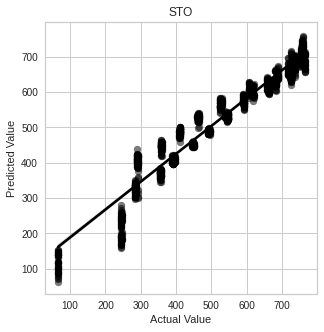

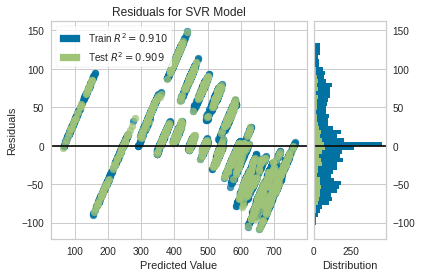

best score: 53.425014
best R2_score: 0.908925
average score: 54.096714 
average R2: 0.905636 


In [39]:
#support vector regressor
testing = 'Regression'
selection = KFold(shuffle=True)
SVR_sub = []
to_excel =[]
results = []
nested = False

print("Support vector regressor")

# params_svr = {'gamma':[pow(10,i) for i in range(1,-7, -1)], 'C':[pow(10,j) for j in range(-1, 7, 1)]}
# params_svr = {'gamma':[ 100, 10, 1, 0.1, 0.01, 0.001],'C':[0.001, 0.01, 0.1, 1, 10, 100]}
params_svr = {'gamma':[1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001],'C':[0.001, 0.01, 0.1, 1, 10, 100]}
# params_svr = {'gamma': [0.001, 0.0001, 1e-05, 1e-06], 'C': [10, 100, 1000, 10000, 100000]}



best_SVR, SVR_scoring = outer_cross_val(X, Y, selection, SVR(), params_svr, 'Regression')

SVR_score, average_SVR, Y_test, Y_pred, R2_score, average_r2 = SVR_scoring
# SVR_score, average_SVR, SVR_cm, Y_test, Y_pred, _, _, ok1, ok2 = SVR_scoring

Y_pred_q = np.round_(Y_pred, decimals = 0)
print("best score: %.6f" % SVR_score)
print("best R2_score: %.6f" % R2_score)
print("average score: %.6f " % average_SVR)
print("average R2: %.6f " % average_r2)

Support vector regressor
Outer Cross Validation
best_nested_model:  SVR(C=100, gamma=0.0001)
nested_score:  53.69963825952508
nested_r2:  0.9023736670656575
Y_test:  [291.7376 291.7727 291.6447 ... 244.0616 244.8658 244.2814]
best_score:  10000
best_nested_model:  SVR(C=100, gamma=0.0001)
nested_score:  53.24474074990203
nested_r2:  0.908181714324709
Y_test:  [291.6447 291.7727 291.6447 ... 244.8658 245.2458 246.1584]
best_score:  53.69963825952508
best_nested_model:  SVR(C=100, gamma=0.0001)
nested_score:  53.8196986832718
nested_r2:  0.9067293908242396
Y_test:  [291.7727 291.7727 291.6447 ... 245.2458 246.1584 244.0616]
best_score:  53.24474074990203
best_nested_model:  SVR(C=100, gamma=0.0001)
nested_score:  54.22187746117074
nested_r2:  0.9068694664229595
Y_test:  [291.6447 291.4724 291.4724 ... 244.0616 245.2458 244.2814]
best_score:  53.24474074990203
best_nested_model:  SVR(C=100, gamma=0.0001)
nested_score:  55.88237671812732
nested_r2:  0.9030486929380314
Y_test:  [290.8108 29

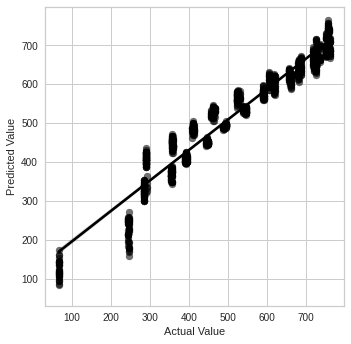

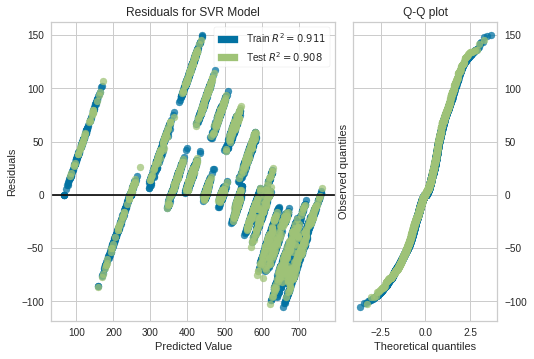

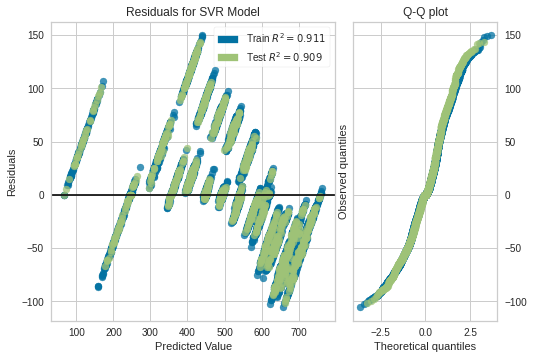

best score: 53.244741
best R2_score: 0.908182
average score: 54.173666 
average R2: 0.905441 


In [ ]:
#support vector regressor
testing = 'Regression'
selection = KFold(shuffle=True)
SVR_sub = []
to_excel =[]
results = []
nested = False

print("Support vector regressor")

# params_svr = {'gamma':[pow(10,i) for i in range(1,-7, -1)], 'C':[pow(10,j) for j in range(-1, 7, 1)]}
# params_svr = {'gamma':[ 100, 10, 1, 0.1, 0.01, 0.001],'C':[0.001, 0.01, 0.1, 1, 10, 100]}
params_svr = {'gamma':[1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001],'C':[0.001, 0.01, 0.1, 1, 10, 100]}
# params_svr = {'gamma': [0.001, 0.0001, 1e-05, 1e-06], 'C': [10, 100, 1000, 10000, 100000]}



best_SVR, SVR_scoring = outer_cross_val(X, Y, selection, SVR(), params_svr, 'Regression')

SVR_score, average_SVR, Y_test, Y_pred, R2_score, average_r2 = SVR_scoring
# SVR_score, average_SVR, SVR_cm, Y_test, Y_pred, _, _, ok1, ok2 = SVR_scoring

Y_pred_q = np.round_(Y_pred, decimals = 0)
print("best score: %.6f" % SVR_score)
print("best R2_score: %.6f" % R2_score)
print("average score: %.6f " % average_SVR)
print("average R2: %.6f " % average_r2)

Support vector regressor
Outer Cross Validation
best_nested_model:  SVR(C=100, gamma=0.0001)
nested_score:  55.03814973039023
nested_r2:  0.904280146491983
Y_test:  [291.3291 291.4724 284.7664 ... 244.0616 243.7642 244.0616]
best_score:  10000
best_nested_model:  SVR(C=100, gamma=0.0001)
nested_score:  54.38056593197841
nested_r2:  0.9080472283220912
Y_test:  [291.4724 291.6447 291.3291 ... 244.8658 244.8658 244.8658]
best_score:  55.03814973039023
best_nested_model:  SVR(C=100, gamma=0.0001)
nested_score:  54.16691046744414
nested_r2:  0.9057461991209925
Y_test:  [291.7727 291.6447 290.8108 ... 244.8658 246.1584 245.2458]
best_score:  54.38056593197841
best_nested_model:  SVR(C=100, gamma=0.0001)
nested_score:  52.320972148549174
nested_r2:  0.9075530488543873
Y_test:  [291.7727 291.7376 291.6447 ... 245.2458 244.0616 244.2814]
best_score:  54.16691046744414
best_nested_model:  SVR(C=100, gamma=0.0001)
nested_score:  55.289340452124776
nested_r2:  0.9003269137460682
Y_test:  [290.8108

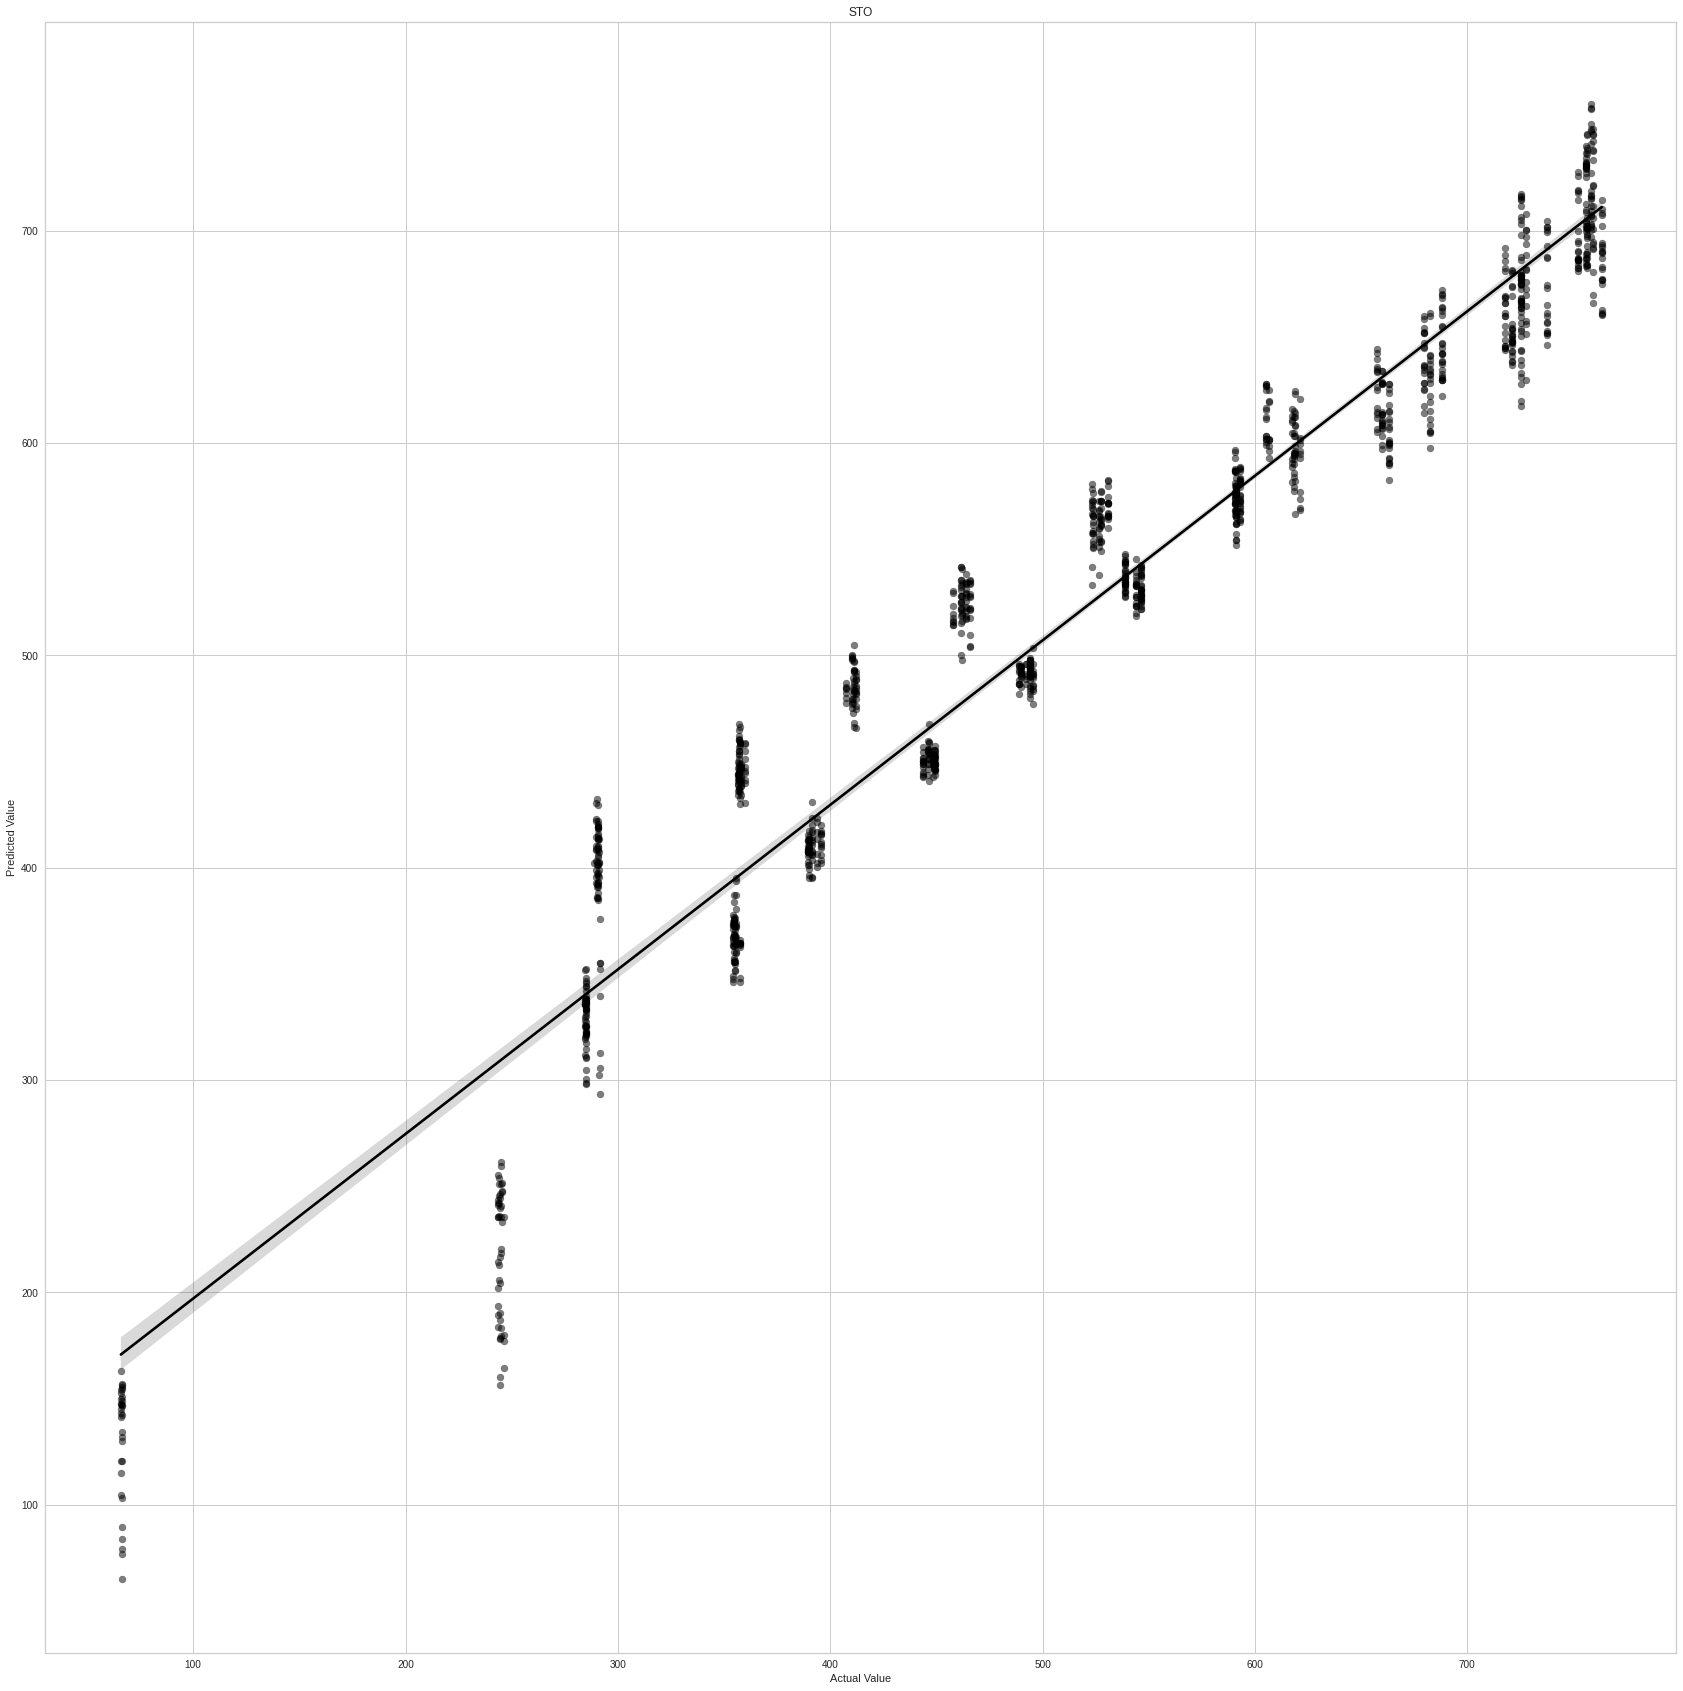

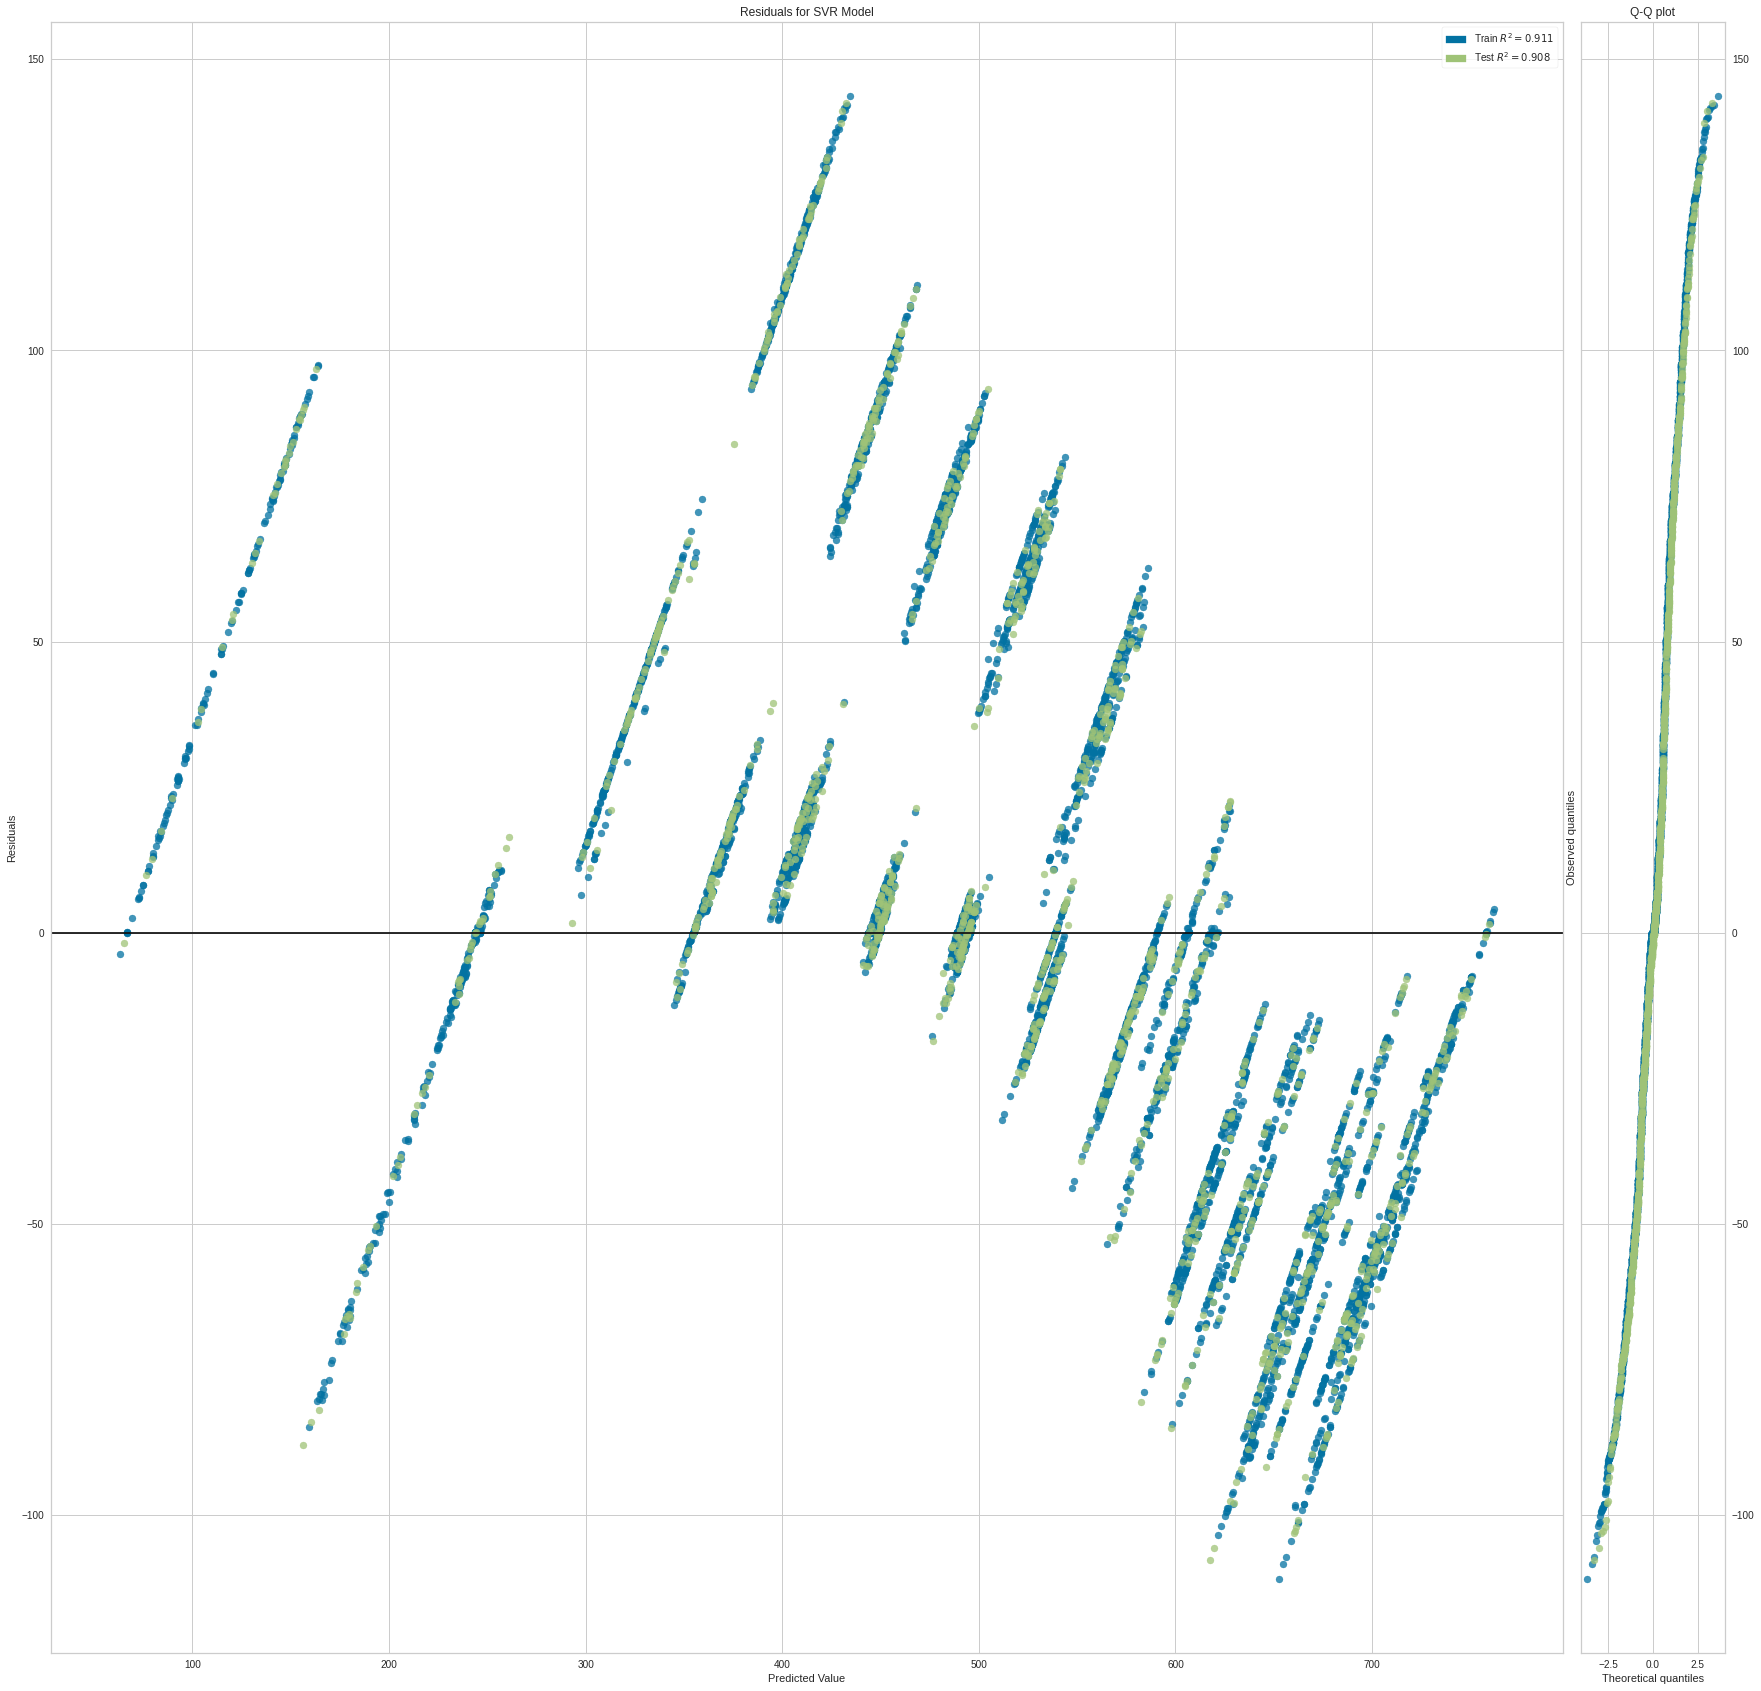

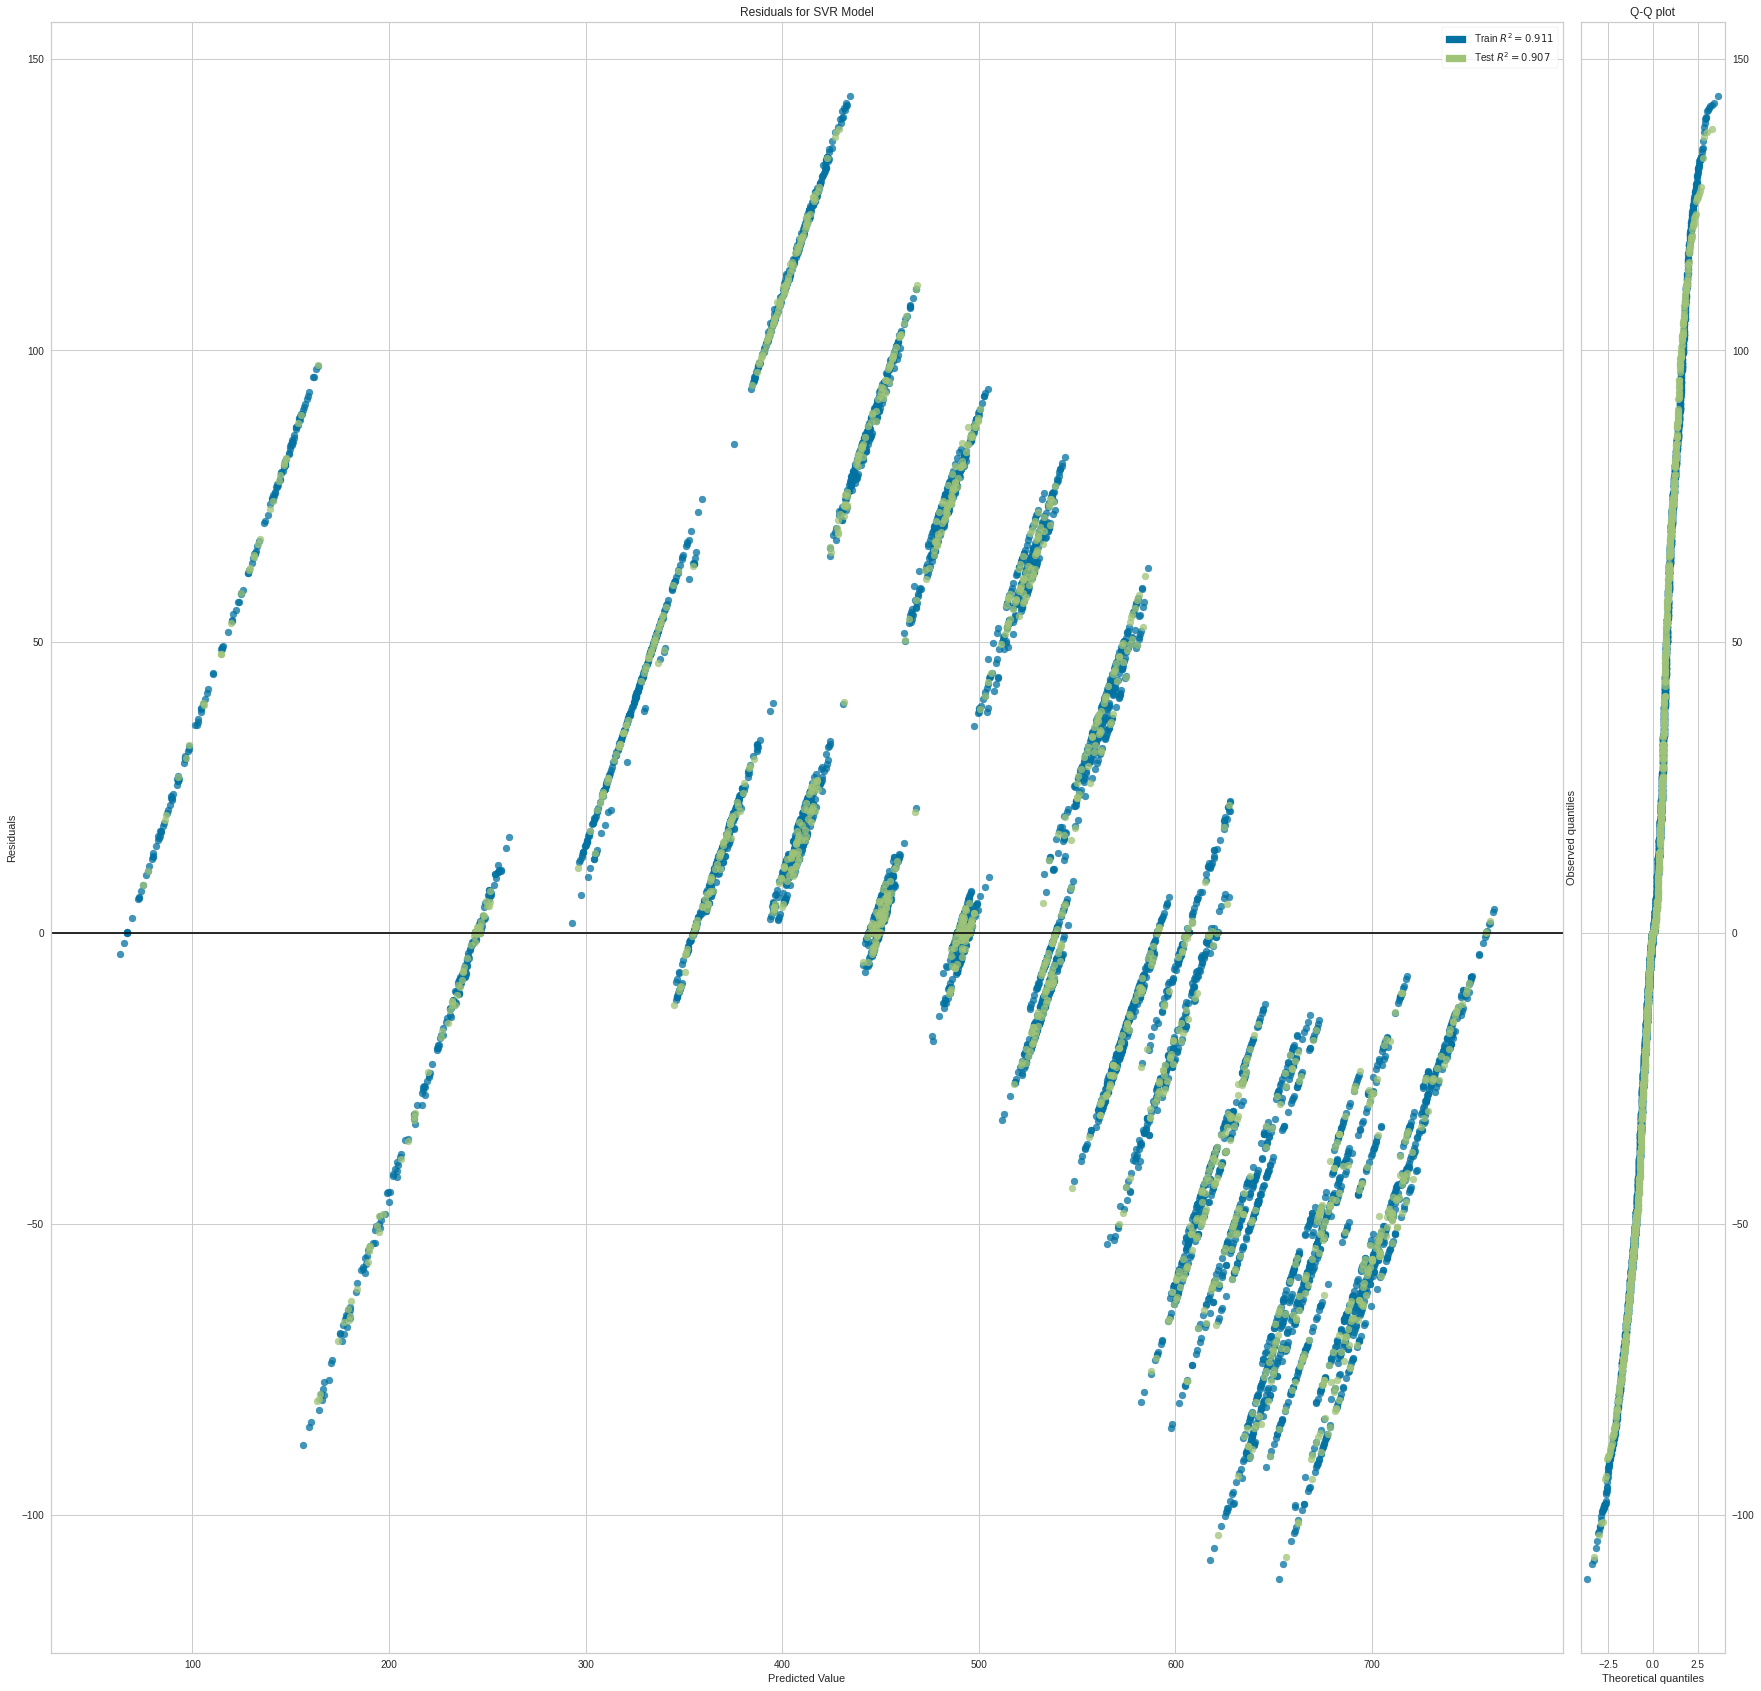

best score: 52.320972
best R2_score: 0.907553
average score: 54.239188 
average R2: 0.905191 


In [21]:
#support vector regressor
testing = 'Regression'
selection = KFold(shuffle=True)
SVR_sub = []
to_excel =[]
results = []
nested = False

print("Support vector regressor")

# params_svr = {'gamma':[pow(10,i) for i in range(1,-7, -1)], 'C':[pow(10,j) for j in range(-1, 7, 1)]}
# params_svr = {'gamma':[ 100, 10, 1, 0.1, 0.01, 0.001],'C':[0.001, 0.01, 0.1, 1, 10, 100]}
params_svr = {'gamma':[1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001],'C':[0.001, 0.01, 0.1, 1, 10, 100]}
# params_svr = {'gamma': [0.001, 0.0001, 1e-05, 1e-06], 'C': [10, 100, 1000, 10000, 100000]}



best_SVR, SVR_scoring = outer_cross_val(X, Y, selection, SVR(), params_svr, 'Regression')

SVR_score, average_SVR, Y_test, Y_pred, R2_score, average_r2 = SVR_scoring
# SVR_score, average_SVR, SVR_cm, Y_test, Y_pred, _, _, ok1, ok2 = SVR_scoring

Y_pred_q = np.round_(Y_pred, decimals = 0)
print("best score: %.6f" % SVR_score)
print("best R2_score: %.6f" % R2_score)
print("average score: %.6f " % average_SVR)
print("average R2: %.6f " % average_r2)